Transformation: Usually used to bring a column (data) distribution close to normal distribution, making it easier to interpret, and find parameters. 

Three major types of transformation: 
1. Functional transformers: 
    Few of the common ones: log, sqr, reciprocal, sqrt etc. 
2. Power Transformers:
    Box-cox and Yeo-Johnson. 
3. Quantile Transform: 



In [93]:
import seaborn as sns
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
import scipy.stats as stats
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

In [7]:
data= sns.load_dataset("titanic")

df= data[['age','survived', 'fare']]
df.head()

,age,survived,fare
0,22.0,0,7.2500
1,38.0,1,71.2833
2,26.0,1,7.9250
3,35.0,1,53.1000
4,35.0,0,8.0500


In [ ]:
# Before transformation check null, thus dealing with it first 
df.isnull().sum()

age         177
survived      0
fare          0
dtype: int64

In [ ]:
df['age'].fillna(df['age'].mean(), inplace= True)

/var/folders/xw/_lnfz_x56cn_zn8_slshkwp80000gn/T/ipykernel_18934/2891901213.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['age'].fillna(df['age'].mean(), inplace= True)
/var/folders/xw/_lnfz_x56cn_zn8_slshkwp80000gn/T/ipykernel_18934/2891901213.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['age'].fillna(df['age'].mean(), inpl

In [11]:
df.isnull().sum()
# no more nulls, we imputed with mean

age         0
survived    0
fare        0
dtype: int64

In [15]:
# Now we will divide data into 2 parts, X and Y, X is feauteres (independent variable), Y (dependent variable)
x= df[['age','fare']]
y= df['survived']

In [52]:
# splitting in train and test (train -80%, test-20%)
# random_state=42, random_state=101, or random_state=7 → all do the same thing: they lock in the shuffle so you’ll get the same split/results every time you rerun.
# The important part is consistency: if you always use 101, you’ll always get the same outcome when your code runs.
# So, random_state=101 just means:"Shuffle the data in a way that’s always repeatable, using 101 as the “recipe” for randomness."
x_train, x_test, y_train, y_test= train_test_split(x,y, test_size=0.2, random_state=101)


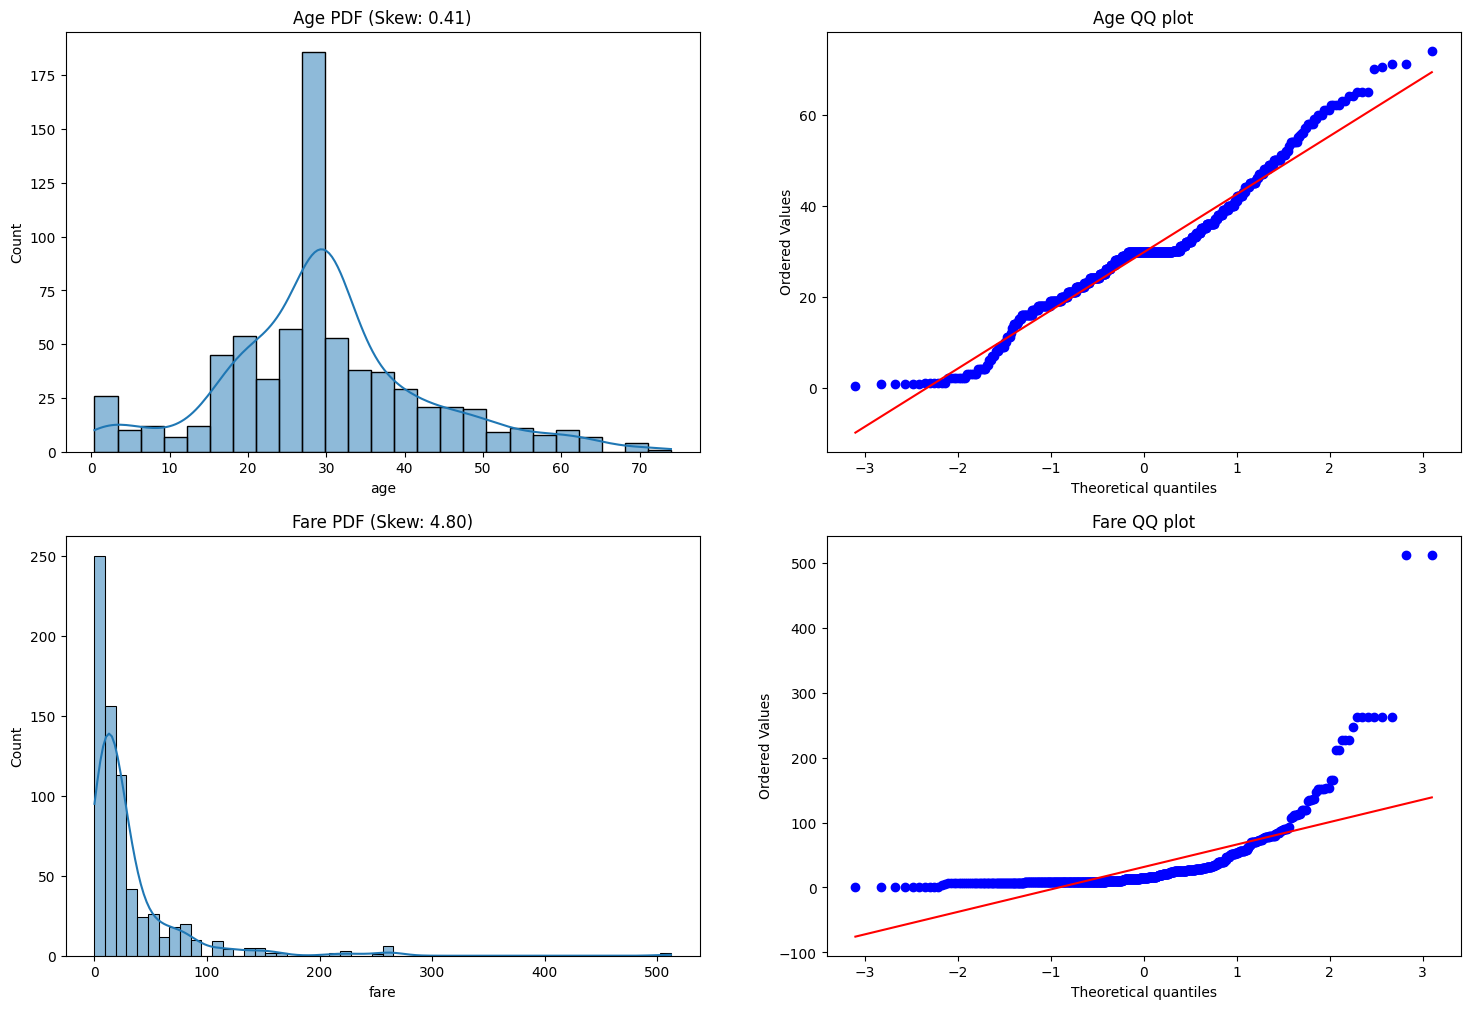

In [ ]:
plt.figure(figsize= (18,12))
# plt.subplot(121)  # 1 row, 2 columns, 1st plot
plt.subplot(221)
sns.histplot(x_train['age'], kde=True)
plt.title(f"Age PDF (Skew: {x_train['age'].skew():.2f})") # for age we have little skewness but it can be assume good enough normal 

plt.subplot(222)
stats.probplot(x_train['age'], dist= 'norm', plot= plt)
plt.title('Age QQ plot')

plt.subplot(223)
sns.histplot(x_train['fare'], kde=True)
plt.title(f"Fare PDF (Skew: {x_train['fare'].skew():.2f})") # For fare we have strong right skewness

plt.subplot(224)
stats.probplot(x_train['fare'], dist= 'norm', plot= plt)
plt.title('Fare QQ plot')

plt.show()

In [66]:
# Before transformation 

clf1= LogisticRegression() # Affect by distribution of the data 
clf2= DecisionTreeClassifier() # Not affect by distribution of the data 

In [55]:
clf1.fit(x_train, y_train)
clf2.fit(x_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [56]:
y_pred1= clf1.predict(x_test)
y_pred2= clf2.predict(x_test)

In [64]:
print("Accuracy LR", accuracy_score(y_test, y_pred1)) # This is about 64%
print("Accuracy DT", accuracy_score(y_test, y_pred2)) # This is about 61%

Accuracy LR 0.6424581005586593
Accuracy DT 0.6145251396648045


In [ ]:
# Lets apply transformations 

df.describe().T
# fares is quite spread out -> min =0 and max= 512
# age is too -> min is 0.42 and max is 80

,count,mean,std,min,25%,50%,75%,max
age,891.0,29.699118,13.002015,0.42,22.0000,29.699118,35.0,80.0000
survived,891.0,0.383838,0.486592,0.00,0.0000,0.000000,1.0,1.0000
fare,891.0,32.204208,49.693429,0.00,7.9104,14.454200,31.0,512.3292


In [82]:
# We are using Functional transformer 

trf_log= FunctionTransformer(func=np.log1p) # as we have have 0 in our data (especially in fare column)

x_train_transform= trf_log.fit_transform(x_train)
x_test_transform= trf_log.transform(x_test)

clf1.fit(x_train_transform, y_train)
clf2.fit(x_train_transform, y_train)

y_pred1= clf1.predict(x_test_transform)
y_pred2= clf2.predict(x_test_transform)

print("Accuracy LR", accuracy_score(y_test, y_pred1)) # this increased from 64% to 67%
print("Accuracy DT", accuracy_score(y_test, y_pred2)) # this increased from 61% to 62% 

# As expected Decission tree accuracy didnt change much, but changed in Logistic regression 

Accuracy LR 0.6703910614525139
Accuracy DT 0.6368715083798883


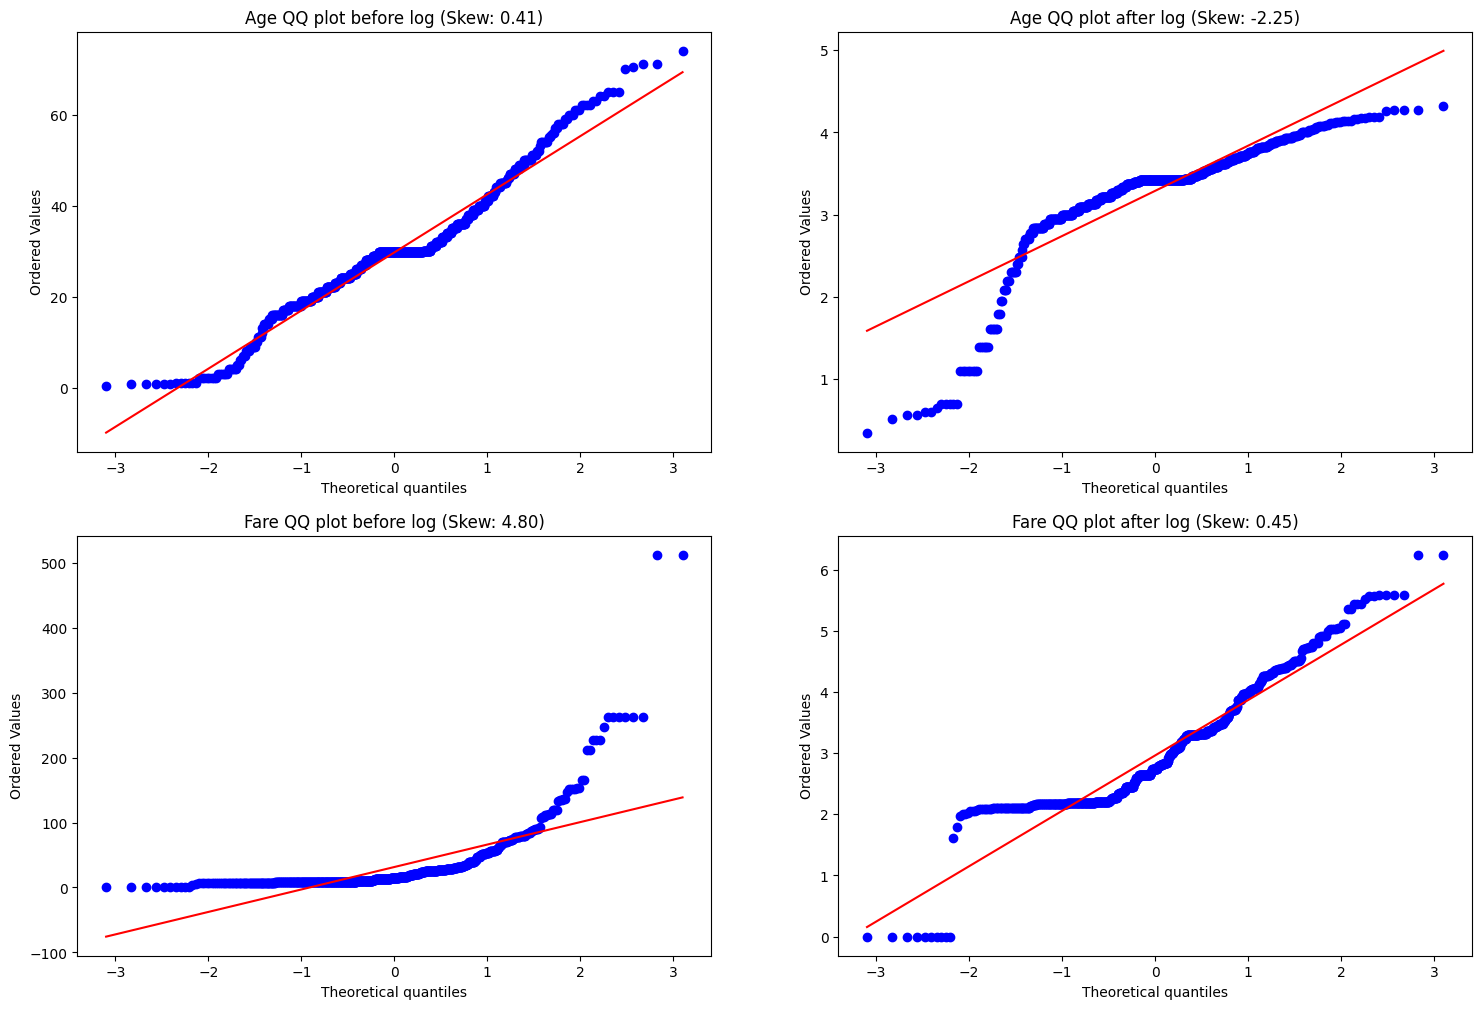

In [91]:
plt.figure(figsize= (18,12))
plt.subplot(221) # 2 row, 2 columns, 1st plot
stats.probplot(x_train['age'], dist= 'norm', plot= plt)
plt.title(f'Age QQ plot before log (Skew: {x_train['age'].skew():.2f})') # skew go worse after transformation

plt.subplot(222)
stats.probplot(x_train_transform['age'], dist= 'norm', plot= plt)
plt.title(f'Age QQ plot after log (Skew: {x_train_transform['age'].skew():.2f})') 

plt.subplot(223)
stats.probplot(x_train['fare'], dist= 'norm', plot= plt)
plt.title(f"Fare QQ plot before log (Skew: {x_train['fare'].skew():.2f})") # skew got much better after transformation

plt.subplot(224)
stats.probplot(x_train_transform['fare'], dist= 'norm', plot= plt)
plt.title(f"Fare QQ plot after log (Skew: {x_train_transform['fare'].skew():.2f})") 

plt.show()

In [92]:
# So we notice that age got worse with transformation and Fare got better with transformation, infact fare is now in threshold for normal enough. 
# We we will only transform fare, and leave age alone. This is feature engineering i.e based on requirements each columns are treated.

In [102]:
trf_col = ColumnTransformer(
    [('log', FunctionTransformer(np.log1p), ['fare'])], # log is name of this step, type of transformation, column 
    remainder='passthrough' # remainder columns are passthrough and not dropped. 
)


x_train_transform_trf2= trf_col.fit_transform(x_train)
x_test_transform_trf2= trf_col.transform(x_test)

clf1.fit(x_train_transform_trf2, y_train)
clf2.fit(x_train_transform_trf2, y_train)

y_pred1= clf1.predict(x_test_transform_trf2)
y_pred2= clf2.predict(x_test_transform_trf2)

print("Accuracy LR", accuracy_score(y_test, y_pred1))
print("Accuracy DT", accuracy_score(y_test, y_pred2)) 

# Still accuracy didnt change much


Accuracy LR 0.659217877094972
Accuracy DT 0.6312849162011173


In [118]:
# So rather than repeating this again and again, lets create a function 

def apply_transform(transform, df):
    # 1) features/target
    X = df[['age', 'fare']].copy()
    y = df['survived'].copy()

    # 2) models
    clf1 = LogisticRegression(max_iter=1000, random_state=101)
    clf2 = DecisionTreeClassifier(random_state=101)

    # 3) column transformer (apply custom transform to 'fare', pass through others)
    trf_col = ColumnTransformer(
        transformers=[
            ('custom', FunctionTransformer(transform, validate=False), ['fare'])
        ],
        remainder='passthrough'
    )
    # Ask sklearn to return pandas DataFrames so we can reference by column name
    trf_col.set_output(transform="pandas")

    # 4) split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=101
    )

    # 5) fit/transform
    X_train_t = trf_col.fit_transform(X_train)
    X_test_t  = trf_col.transform(X_test)

    # 6) train + predict
    clf1.fit(X_train_t, y_train)
    clf2.fit(X_train_t, y_train)
    y_pred1 = clf1.predict(X_test_t)
    y_pred2 = clf2.predict(X_test_t)

    print("Accuracy (LogReg):", accuracy_score(y_test, y_pred1))
    print("Accuracy (DecTree):", accuracy_score(y_test, y_pred2)) # chekc cross_val_score function once

    # 7) QQ plots before vs after
    # The transformed fare column will be named 'custom__fare' with set_output("pandas")
    fare_before = X_train['fare']
    fare_after  = X_train_t['custom__fare']

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    stats.probplot(fare_before, dist='norm', plot=plt)
    plt.title(f"Fare QQ (before)  | Skew: {fare_before.skew():.2f}")

    plt.subplot(1, 2, 2)
    stats.probplot(fare_after, dist='norm', plot=plt)
    plt.title(f"Fare QQ (after)   | Skew: {fare_after.skew():.2f}")

    plt.tight_layout()
    plt.show()


Accuracy (LogReg): 0.659217877094972
Accuracy (DecTree): 0.6312849162011173


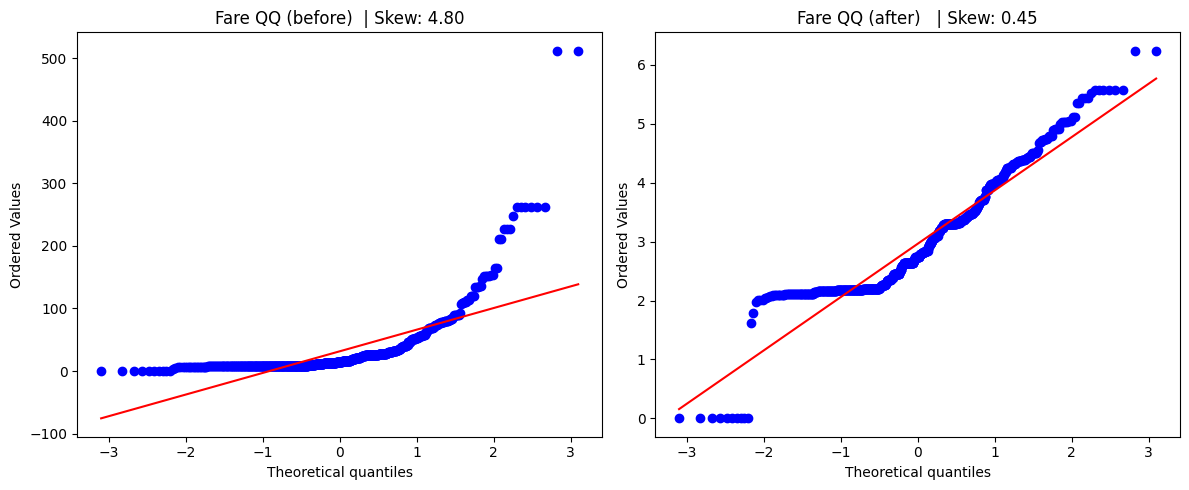

In [116]:
apply_transform(np.log1p, df)

Accuracy (LogReg): 0.5921787709497207
Accuracy (DecTree): 0.6201117318435754


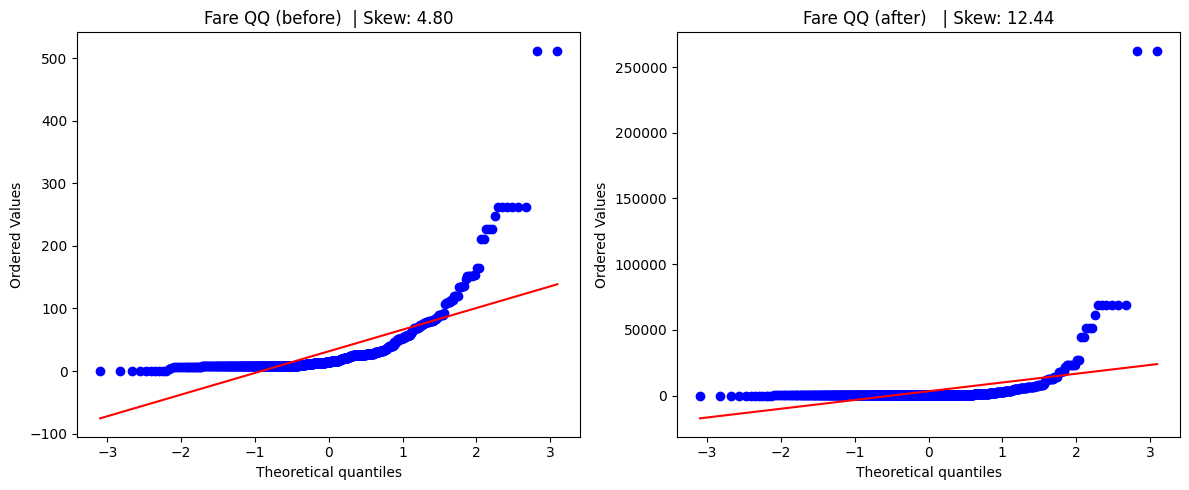

In [111]:
apply_transform(np.square, df)

Accuracy (LogReg): 0.6536312849162011
Accuracy (DecTree): 0.6256983240223464


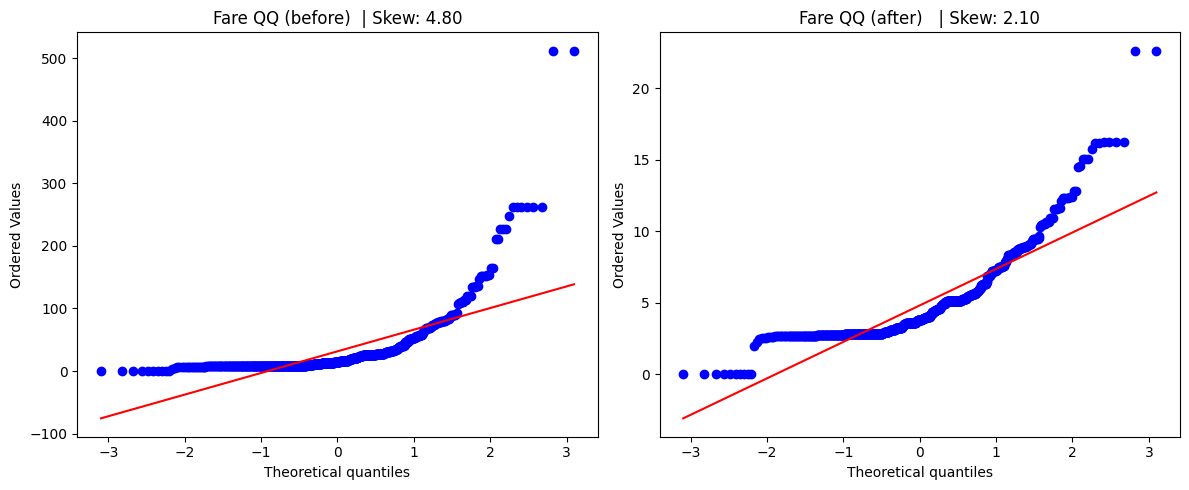

In [112]:
apply_transform(np.sqrt, df)

In [117]:
# apply_transform(np.reciprocal, df) # will blow up as we have 0 in our columns 
# so will np.log

In [119]:
# Better option is box-cox and yeo-johnson transformation